In [1]:
from foundry.util.runtime import setup
setup()

from image_diffusion.main import logger
logger.setLevel('INFO')

import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train

from foundry.core.dataclasses import dataclass, replace

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
from typing import Sequence

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})
# Use only the CPU for visualizations
# jax.config.update("jax_platform_name", "cpu")

print("Devices:", jax.devices())

Devices: [CudaDevice(id=0)]


In [2]:
import foundry.util.serialize
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image-diffusion-eval/evaluation:v31")
entries = list(artifact.files())
data_url = entries[-1]._attrs["directUrl"]
eval_data = foundry.util.serialize.load(data_url)
checkpoint_url = eval_data.checkpoint_uri
checkpoint = foundry.util.serialize.load(checkpoint_url)

In [3]:
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())
latents = test_data.cond

[21:36:33] INFO     image_diffusion - Learning T-SNE embedding...


In [4]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(ax, zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    ax.scatter(zs[:, 0], zs[:, 1], c=colors, s=5, **kwargs)

def map(f, batch_size=None):
    return lambda *x: jax.lax.map(lambda x: f(*x), x, batch_size=batch_size)

def smoothing_eval(xs, ys, vals, radius=1/32):
    x_min, x_max = npx.min(xs), npx.max(xs)
    y_min, y_max = npx.min(ys), npx.max(ys)
    x_bw, y_bw = (x_max - x_min)*radius, (y_max - y_min)*radius

    def eval(x, y):
        dists_sqr = (xs - x)**2/(x_bw**2) + (ys - y)**2/(y_bw**2)
        log_kernel = -dists_sqr
        log_kernel = log_kernel - jax.scipy.special.logsumexp(log_kernel)
        return npx.exp(jax.scipy.special.logsumexp(log_kernel, b=vals))
    return eval

def smoothed_colormesh(ax, eval, *, 
        x_min, x_max, y_min, y_max,
        val_clip=None, **kwargs):
    xs_high = npx.linspace(x_min, x_max, 256)
    ys_high = npx.linspace(y_min, y_max, 256)
    XS_high, YS_high = npx.meshgrid(xs_high, ys_high)
    vals_high = map(map(eval, batch_size=4), batch_size=4)(XS_high, YS_high)
    if val_clip is not None:
        vals_high = vals_high.clip(-val_clip, val_clip)
    # plt.scatter(xs, ys, c=vals, **kwargs)
    return ax.pcolormesh(xs_high, ys_high, vals_high, **kwargs, rasterized=True)

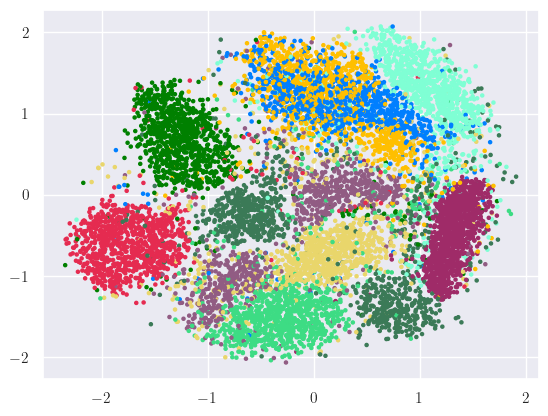

In [5]:
fig, ax = plt.subplots()
embed_scatter(ax, latents, test_data.label)
fig.show()

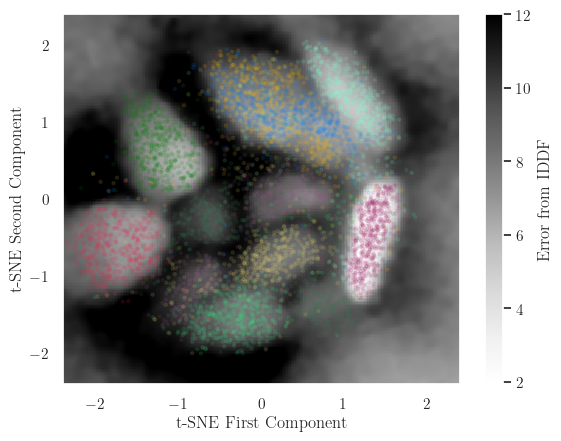

In [6]:
def heatmap(fig, ax, nw_error=True):
    mesh = smoothed_colormesh(ax,
        smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            npx.mean(eval_data.nw_error if nw_error else eval_data.lin_error, -1),
            radius=1/64
        ),
        x_min=-2.4, x_max=2.4,
        y_min=-2.4, y_max=2.4,
        val_clip=12,
        cmap="Greys"
    )
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_xlabel("t-SNE First Component")
    ax.set_ylabel("t-SNE Second Component")
    cbar = fig.colorbar(mesh)

    if not nw_error:
        ax.scatter(eval_data.keypoints[:,0], eval_data.keypoints[:,1], color="red")

    if nw_error:
        cbar.set_label("Error from IDDF")
    else:
        cbar.set_label("Schedule Inconsistency")
    embed_scatter(ax, latents[::2], test_data.label[::2], alpha=0.1)

fig, ax = plt.subplots()
heatmap(fig, ax)
fig.savefig("error_visualization.pdf", bbox_inches="tight")
fig.show()

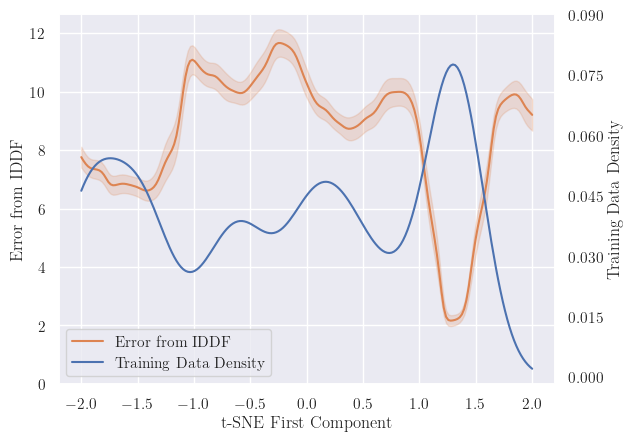

In [7]:
def latent_density(x):
    sigma = 0.2
    log_density = -npx.sum(npx.square(latents - x), axis=-1)/(2*sigma**2)
    N = log_density.shape[0]
    log_density = jax.scipy.special.logsumexp(log_density)
    log_norm = 1/2*npx.log(2*npx.pi) + npx.log(sigma) + npx.log(N)
    return npx.exp(log_density - log_norm)

def density_plot(ax1, nw_error=True):
    t = npx.linspace(-2, 2, 200)
    zs = npx.array([1, 0])[None,:]*t[:,None] + npx.array([[0, -0.5]])
    density = F.vmap(latent_density)(zs)
    nw_err = F.vmap(smoothing_eval(
        eval_data.cond[:,0], eval_data.cond[:,1], 
        npx.mean(eval_data.nw_error if nw_error else eval_data.lin_error, -1),
        radius=1/64,
    ))(zs[:,0], zs[:,1])
    nw_std = F.vmap(smoothing_eval(
        eval_data.cond[:,0], eval_data.cond[:,1], 
        npx.std(eval_data.nw_error if nw_error else eval_data.lin_error, -1),
        radius=1/64,
    ))(zs[:,0], zs[:,1]) / npx.sqrt(eval_data.nw_error.shape[-1])

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    ax1.set_xlabel("t-SNE First Component")

    h1, = ax1.plot(t, nw_err, color=colors[1], label="Error from IDDF")
    ax1.fill_between(t, nw_err - nw_std, nw_err + nw_std, color=colors[1], alpha=0.2)
    if nw_error:
        ax1.set_ylabel("Error from IDDF")
    else:
        ax1.set_ylabel("Schedule Inconsistency")

    ax2 = ax1.twinx()

    h2, = ax2.plot(t, density, color=colors[0], label="Training Data Density")
    ax2.set_ylabel("Training Data Density")

    ax2.grid(False)
    ax1.grid(True)

    ax1.set_yticks(npx.linspace(0, 12, 7))
    ax2.set_yticks(npx.linspace(0, 0.09, 7))
    ax1.tick_params(axis="y", left=False, right=False)
    ax2.tick_params(axis="y", left=False, right=False)
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

    ax2.legend(handles=[h1,h2], loc="lower left")

fig, ax = plt.subplots()
density_plot(ax)
fig.savefig("latents_slice.pdf", bbox_inches="tight")
fig.show()

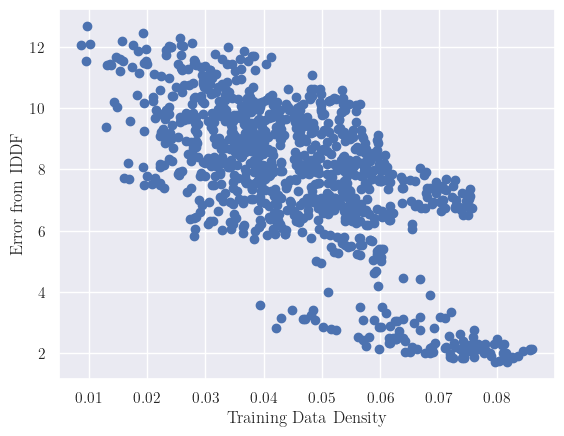

In [8]:
def density_scatter(ax, s=None, nw_error=True):
    Xs, Ys = latents[::10].T
    density = F.vmap(latent_density)(npx.stack((Xs, Ys), -1))
    error = F.vmap(smoothing_eval(
        eval_data.cond[:,0], 
        eval_data.cond[:,1], 
        (eval_data.nw_error if nw_error else eval_data.lin_error).mean(-1),
        radius=1/256
        ))(Xs, Ys)

    ax.set_ylabel("Error from IDDF")
    ax.set_xlabel("Training Data Density")
    ax.scatter(density, error, s=s)

fig, ax = plt.subplots()
density_scatter(ax)
fig.savefig("density_vs_error.pdf", bbox_inches="tight")
fig.show()

In [20]:
# Load the historical evaluation data
artifact = api.artifact("dpfrommer-projects/image-diffusion-eval/evaluation:v36")
historical_data = list(a._attrs["directUrl"] for a in artifact.files())
historical_data = {int(e.split("/")[-1].split(".")[0]): foundry.util.serialize.load(e) for e in historical_data}

run = api.run("dpfrommer-projects/image-diffusion/runs/wbs0i39v")
training_loss_history = run.history(keys=["test/loss"])

<>:32: SyntaxWarning: invalid escape sequence '\g'
<>:32: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_2484142/2170263013.py:32: SyntaxWarning: invalid escape sequence '\g'
  h2, = ax.plot(data["iteration"], data["error"], color=colors[1], label="IDDF Error (Density $\geq$ 0.06)")


/tmp/ipykernel_2484142/2170263013.py:32: SyntaxWarning: invalid escape sequence '\g'
  h2, = ax.plot(data["iteration"], data["error"], color=colors[1], label="IDDF Error (Density $\geq$ 0.06)")


NameError: name 'h1' is not defined

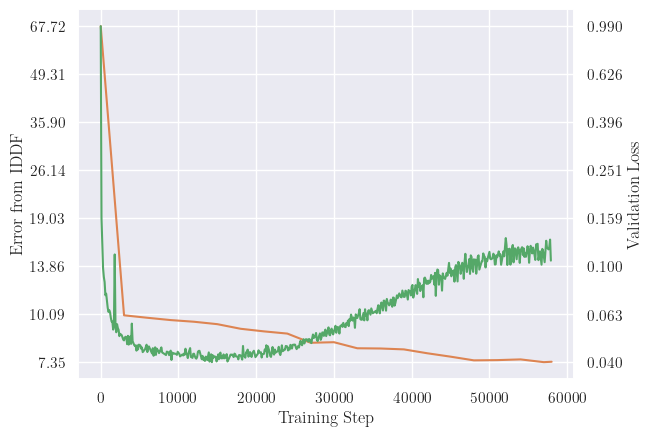

In [27]:
import pandas as pd

def plot_history(ax):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax.set_xlabel("Training Step")
    ax.set_ylabel("Error from IDDF")
    # ax.plot(eval_data.history["step"], eval_data.history["nw_error"])

    sample_points = foundry.random.normal(foundry.random.key(42), (256, 2))
    sample_points = sample_points / npx.linalg.norm(sample_points, axis=-1, keepdims=True)
    sample_points = sample_points * foundry.random.uniform(foundry.random.key(42), (256, 1), minval=0., maxval=2.3)
    Xs, Ys = sample_points.T
    density = F.vmap(latent_density)(npx.stack((Xs, Ys), -1))
    def proc(i, h):
        e = h.nw_error[0,0]
        error = F.vmap(smoothing_eval(
            h.cond[:,0], 
            h.cond[:,1], 
            h.nw_error.mean(-1), radius=1/256))(Xs, Ys)
        low_density = density < 0.01
        low_density_error = error[low_density]
        high_density_error = error[high_density]
        return {"iteration": i, "error": npx.mean(error)} # "low_density": npx.mean(low_density_error), "high_density": npx.mean(high_density_error)}

    data = pd.DataFrame([proc(i, h) for i, h in historical_data.items()])
    data = data[data["iteration"] >= 0000]
    training_data = training_loss_history[training_loss_history["_step"] >= 0000]

    # h1, = ax.plot(data["iteration"], data["low_density"], color=colors[0], label="IDDF Error (Density $\leq$ 0.01)")
    # h2, = ax.plot(data["iteration"], data["high_density"], color=colors[1], label="IDDF Error (Density $\geq$ 0.06)")
    h2, = ax.plot(data["iteration"], data["error"], color=colors[1], label="IDDF Error (Density $\geq$ 0.06)")
    ax2 = ax.twinx()
    ax2.set_ylabel("Validation Loss")
    h3, = ax2.plot(training_data["_step"], training_data["test/loss"], color=colors[2], label="Validation Loss")
    
    ax.set_yscale("log")
    ax2.set_yscale("log")

    l_min, l_max = data["error"].min(), data["error"].max()
    l_ticks = npx.round(npx.exp(npx.linspace(npx.log(l_min), npx.log(l_max), 8)), 3)
    ax.set_yticks(l_ticks)

    r_min, r_max = training_data["test/loss"].min(), training_data["test/loss"].max()
    r_ticks = npx.round(npx.exp(npx.linspace(npx.log(r_min), npx.log(r_max), 8)), 3)
    ax2.set_yticks(r_ticks)
    ax2.grid(False)

    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax2.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.tick_params(axis="y", which='both', left=False, right=False)
    ax2.tick_params(axis="y", which='both', left=False, right=False)

    ax2.legend(handles=[h1, h2, h3], loc="upper right")

fig, ax = plt.subplots()
plot_history(ax)
fig.show()

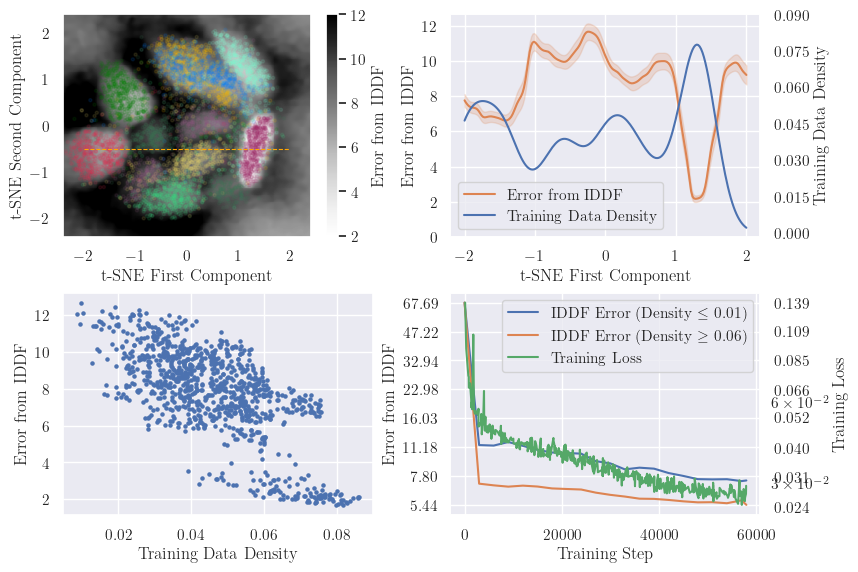

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6.5))
heatmap(fig, ax1)
ax1.add_line(plt.Line2D([-2, 2], [-0.5, -0.5], color="orange", linestyle="--", linewidth=0.8))
density_plot(ax2)
density_scatter(ax3, s=5)
plot_history(ax4)
fig.subplots_adjust(wspace=0.25, hspace=0.25)
fig.savefig("combined.pdf", bbox_inches="tight", dpi=250)
fig.show()


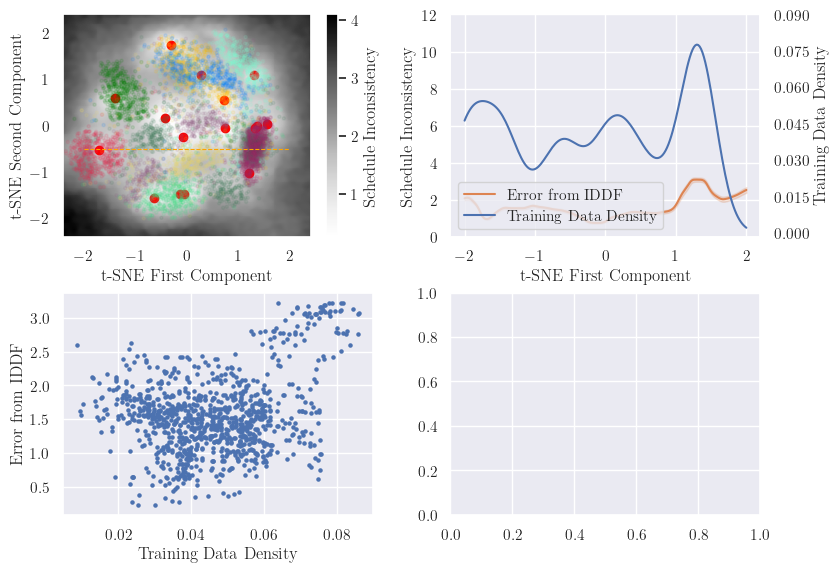

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6.5))
heatmap(fig, ax1, nw_error=False)
ax1.add_line(plt.Line2D([-2, 2], [-0.5, -0.5], color="orange", linestyle="--", linewidth=0.8))
density_plot(ax2, nw_error=False)
density_scatter(ax3, s=5, nw_error=False)
fig.subplots_adjust(wspace=0.25, hspace=0.25)
fig.savefig("combined_interpolant.pdf", bbox_inches="tight", dpi=250)
fig.show()